In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt

In [2]:
# Load engineered features
df = pd.read_csv("data/features_account_level.csv")

print(df.shape)
df.head()

(5000, 16)


,account_id,total_inflow_amount,total_outflow_amount,num_unique_senders,num_unique_receivers,num_incoming_txn,num_outgoing_txn,txn_velocity_per_day,num_txn_below_threshold,proportion_txn_below_threshold,avg_txn_amount,std_txn_amount,zscore_outflow,net_flow,ratio_in_out,is_mule
0,0,62431.88,82033.00,19,22,19,22,0.261905,18,0.947368,3728.772727,1989.944834,0.629709,-19601.12,0.761058,0
1,1,46768.85,80166.27,17,25,17,25,0.280899,17,1.000000,3206.650800,1456.849877,0.534451,-33397.42,0.583398,0
2,2,50852.16,90322.63,17,26,17,26,0.317073,17,1.000000,3473.947308,1404.153017,1.052725,-39470.47,0.563006,0
3,3,66541.04,59010.13,21,17,21,17,0.215190,21,1.000000,3471.184118,2006.422444,-0.545137,7530.91,1.127621,0
4,4,60056.69,67373.54,16,19,16,19,0.250000,16,1.000000,3545.975789,1983.661325,-0.118356,-7316.85,0.891399,0


In [3]:
# RULE THRESHOLDS (tunable)
R1 = df["num_unique_senders"] > 30
R2 = df["num_unique_receivers"] > 30
R3 = df["txn_velocity_per_day"] > 0.30
R4 = df["proportion_txn_below_threshold"] > 0.98
R5 = df["zscore_outflow"] > 1.50

# Combine (OR)
df["rule_alert"] = (R1 | R2 | R3 | R4 | R5).astype(int)

In [4]:
df["rule_alert"].value_counts()

rule_alert
1    4409
0     591
Name: count, dtype: int64

In [5]:
y_true = df["is_mule"]
y_pred = df["rule_alert"]

In [6]:
print("Recall:", round(recall_score(y_true, y_pred), 3))
print("Precision:", round(precision_score(y_true, y_pred), 3))
print("F1:", round(f1_score(y_true, y_pred), 3))
print("ROC-AUC:", round(roc_auc_score(y_true, y_pred), 3))

Recall: 0.947
Precision: 0.032
F1: 0.062
ROC-AUC: 0.533


In [7]:
alert_volume = df["rule_alert"].mean()
print("Alert Volume (% flagged):", round(alert_volume*100, 2), "%")

Alert Volume (% flagged): 88.18 %


In [8]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[ 583, 4267],
       [   8,  142]])

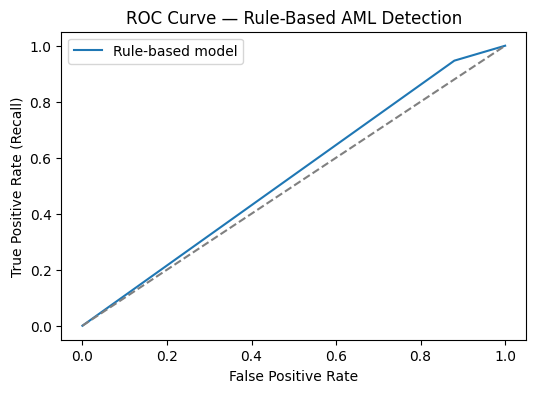

In [9]:
fpr, tpr, thresholds = roc_curve(y_true, df["rule_alert"])

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="Rule-based model")
plt.plot([0,1], [0,1], '--', color='gray')
plt.title("ROC Curve — Rule-Based AML Detection")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend()
plt.show()

In [10]:
results = {
    "Recall": recall_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred),
    "F1 Score": f1_score(y_true, y_pred),
    "ROC-AUC": roc_auc_score(y_true, y_pred),
    "Alert Volume": alert_volume
}

pd.DataFrame([results])

,Recall,Precision,F1 Score,ROC-AUC,Alert Volume
0,0.946667,0.032207,0.062294,0.533436,0.8818
